# Efficient Frontier

This is a demo for using the efficient frontier optimisers of `PortfolioOptimiser.jl`.

In [1]:
using PortfolioOptimiser
using CSV, DataFrames, Plots, CovarianceEstimation, LinearAlgebra, Statistics

## Loading data

All our functions take AbstractArray or Tuple arguments, not DataFrame or TimeArray data. The reason is to keep the code as generic and performant as possible. Julia is fast enough that it can be used in performance critical applications, so we remove the data wrangling from the equation, and we leave it up to the user to decide how they want to handle their data.

For the example we'll use CSV and DataFrames to load our historical prices. 

We have the data in the `assets` folder, but the package [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) can be used to download stock data.

In [3]:
hist_prices = CSV.read("./assets/stock_prices.csv", DataFrame)
dropmissing!(hist_prices)

,date,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-09-19,592.82,94.7721,77.91,93.89,331.32,23.421,3.81,70.0099
2,2014-09-22,584.158,94.866,76.8,89.89,324.5,23.2339,3.76,69.527
3,2014-09-23,577.952,96.3492,78.29,87.17,323.63,23.1805,3.69,68.8801
4,2014-09-24,584.775,95.5137,78.54,90.57,328.21,23.1003,3.7,70.2286
5,2014-09-25,571.915,91.8715,77.22,88.92,321.93,22.7618,3.63,69.3539
6,2014-09-26,573.944,94.575,78.79,90.46,323.21,22.833,3.6,69.691
7,2014-09-29,573.208,93.9743,79.0,88.75,321.82,22.646,3.55,69.3175
8,2014-09-30,574.203,94.575,79.04,88.85,322.44,22.8241,3.41,69.6728
9,2014-10-01,565.162,93.1013,76.55,86.1,317.46,22.4143,3.35,69.3539


## Returns

`PortfolioOptimiser.jl` calculates a variety of returns and expected returns from the historical price data. Here we use daily prices, but we can use any price frequency. When using other price frequencies, you should adjust the `freq` parameters in the corresponding functions.

We can get both regular and log returns with the function `returns_from_prices`. 

Log returns are useful because they can be added instead of multiplied when compounding, however the function defaults to regular returns.

In [4]:
returns = returns_from_prices(hist_prices[!, 2:end])
log_returns = returns_from_prices(hist_prices[!, 2:end], true)
exp.(log_returns) .- 1 ≈ returns

true

We can also recover relative prices from the returns. Since DataFrames does not define `cumprod` we must use arrays.

In [5]:
rel_prices = prices_from_returns(Matrix(returns[!, :]))
rel_prices_log = prices_from_returns(Matrix(log_returns[!, :]), true)
rel_prices ≈ rel_prices_log

true

We can reconstruct the original prices by multiplying the first entry of historical prices by the corresponding relative prices.

In [6]:
reconstructed_prices = (rel_prices' .* Vector(hist_prices[1, 2:end]))'
reconstructed_prices ≈ Matrix(hist_prices[!, 2:end])

true

## Expected returns

We have a few ways of calculating a variety of expected/mean returns:

- arithmetic mean
- exponentially weighted mean
- capital asset pricing model
- exponentially weighted capital asset pricing model

The optional keyword arguments are further explained in the docs.

Typically, exponentially-weighted returns are more predictive of future returns, as they assign higher weights to more recent values. 

The CAPM is a more stable return measure because it accounts for the return value, covariance to other assets, covariance to the market, and risk free rate. The exponential version simply uses exponential returns to calculate the mean market return. When you don't provide a vector of market returns to the CAPM models (which is the case here), they are calculated as the mean of the returns of the assets provided.

In [19]:
# Number of rows and columns for calculating the exponential weights.
num_rows = nrow(returns)
num_cols = ncol(returns)

# Split the returns 
past_returns = Matrix(returns[1:div(num_rows, 2), :])
future_returns = Matrix(returns[(div(num_rows, 2)+1):end, :])

# Arithmetic future returns.
mean_future_rets = ret_model(MRet(), future_returns)

# Various past mean returns.
mean_ret = ret_model(MRet(), past_returns)
e_mean_ret = ret_model(EMRet(), past_returns, span = num_rows / 2)
capm_ret = ret_model(CAPMRet(), past_returns)
e_capm_ret = ret_model(ECAPMRet(), past_returns, cspan = num_rows / 2, rspan = num_rows / 2)

DataFrame(future = mean_future_rets, mean = mean_ret, emean = e_mean_ret, capm = capm_ret, ecapm = e_capm_ret)

┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30
┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser D:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30


,future,mean,emean,capm,ecapm
,Float64,Float64,Float64,Float64,Float64
1,0.251907,0.084095,0.103919,0.0733891,0.113483
2,0.42774,-0.0192506,-0.105036,0.0775557,0.125335
3,0.235747,0.240336,0.305976,0.0816804,0.132916
4,0.576821,-0.0989912,0.0241145,0.0865019,0.146773
5,0.474416,0.543596,0.650579,0.0862735,0.139536
6,-0.362388,0.125079,0.176711,0.0712196,0.116269
7,0.44086,0.182588,2.02136,0.142432,0.292654
8,0.12899,-0.00619495,0.102599,0.0519984,0.0759931
9,0.609574,-0.120898,-0.128834,0.0976724,0.183283


Note how there are warnings regarding the covariance matrix not being positive definite. These are from the CAPM returns, as they use the asset covariance with respect to the market returns. 

Using [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl) and `CustomCov()` or `CustomSCov()` (see Risk Models section) via the `cov_type` keyword argument, we can use a more robust covariance measurement for the CAPM returns

Downside risk tends to be more stable, to prove this we use both the shrunken covariance and shrunken semicovariance. 

Note that we can use any covariance estimator as defined by `cov` from `Statistics` or `StatsBase` by simply providing it via the `custom_cov_estimator` keyword argument. The default is to use the sample covariance for `CAPMRet()`, and exponentially weighted covariance for `ECAPMRet()`.

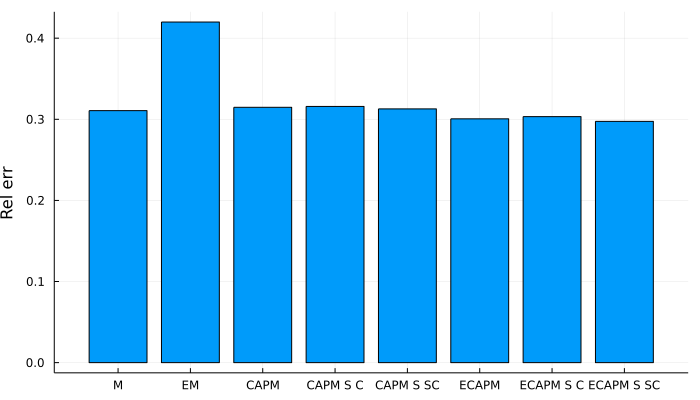

[0.31063526256932866, 0.419903378509077, 0.31474257003293027, 0.31587044704120426, 0.31284742055462733, 0.30055327745082006, 0.30327567778804315, 0.29747040200051755]


In [24]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

capm_ret_shrunken_cov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_cov = ret_model(
    ECAPMRet(),
    past_returns,
    cspan=num_rows / 2,
    rspan=num_rows / 2,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

capm_ret_shrunken_scov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_scov = ret_model(
    ECAPMRet(),
    past_returns,
    cspan=num_rows / 2,
    rspan=num_rows / 2,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

errors = Float64[]
push!(errors, sum(abs.(mean_future_rets - mean_ret)))
push!(errors, sum(abs.(mean_future_rets - e_mean_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_scov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_scov)))

errors /= length(mean_future_rets)

fig = plot(
    ["M", "EM", "CAPM", "CAPM S C", "CAPM S SC", "ECAPM", "ECAPM S C", "ECAPM S SC"],
    errors,
    ylabel="Rel err",
    legend=false,
    size=(700, 400),
    seriestype=:bar,
)

display(fig)

println(errors)

Returns are chaotic and unpredictable, so it's often better to optimise portfolios without considering them. The average absolute errors are all over 30 %, so for this case, a portfolio that has an expected return of 10 %, will most likely return between [-20, 40] %.

Minimum variance, semivariance, CVaR and CDaR tend to give more stable portfolios than ones that take returns into consideration.

We can plot all the return types together to see how they correlate to each other.

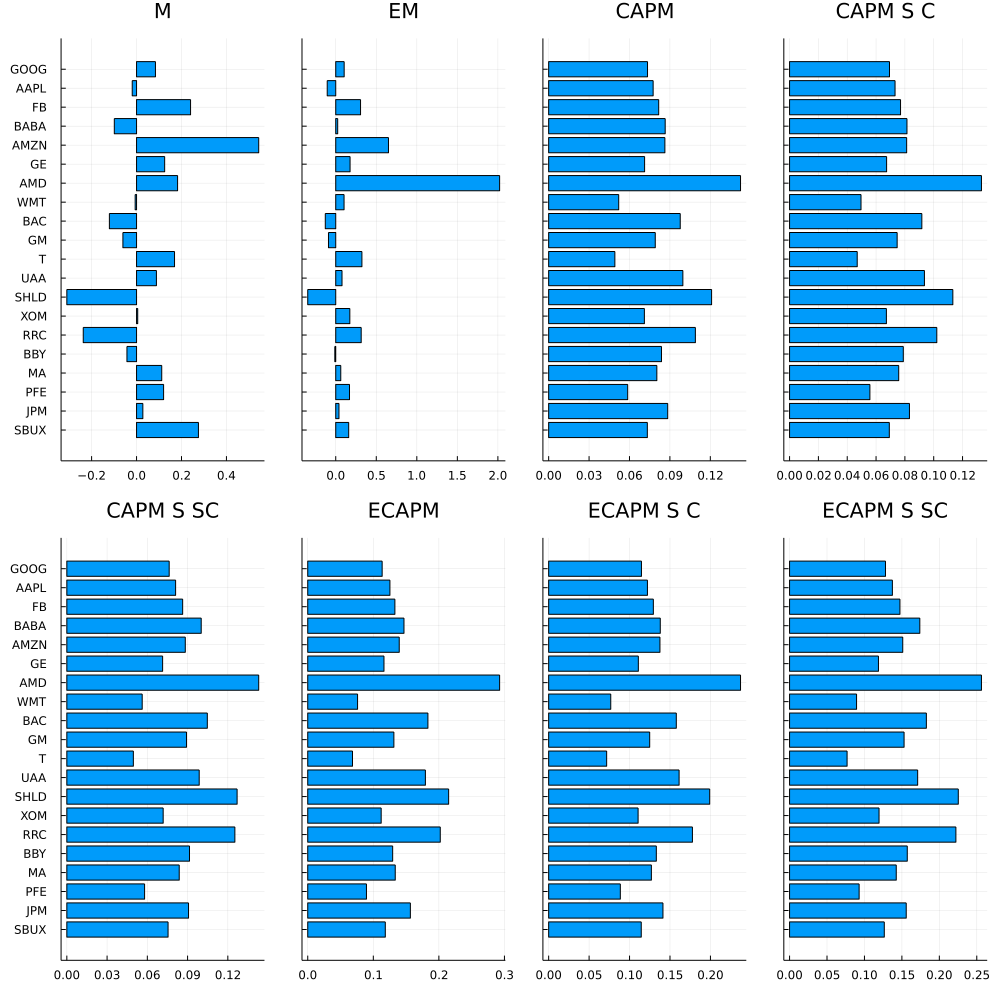

In [27]:
l = @layout [a b c d; e f g h]

fig1 = bar(
    mean_ret,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "M",
)

fig2 = bar(
    e_mean_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "EM",
)

fig3 = bar(
    capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM",
)

fig4 = bar(
    capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S C",
)

fig5 = bar(
    capm_ret_shrunken_scov,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S SC",
)

fig6 = bar(
    e_capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM",
)

fig7 = bar(
    e_capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S C",
)

fig8 = bar(
    e_capm_ret_shrunken_scov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S SC",
)

plot(fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, layout = l, size = (1000, 1000))

There's strong correspondence between exponential and non-exponentially weighted return types. CAPM returns are a little bit different as they account for an asset's relationship to the market via a covariance matrix.

## Risk models

We also have a few built-in risk models. However, using CustomCov() and CustomSCov() we can make use of other models, such as those found in [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl), and use other types of weights other than exponential ones.

We provide a variety of covariance measures:

- sample covariance
- exponentially weighted sample covariance
- semicovariance
- exponentially weighted semicovariance
- custom covariance
- custom semicovariance

The optional keyword arguments are further explained in the docs.

We can see which covariance matrix estimates the future asset variances the best.

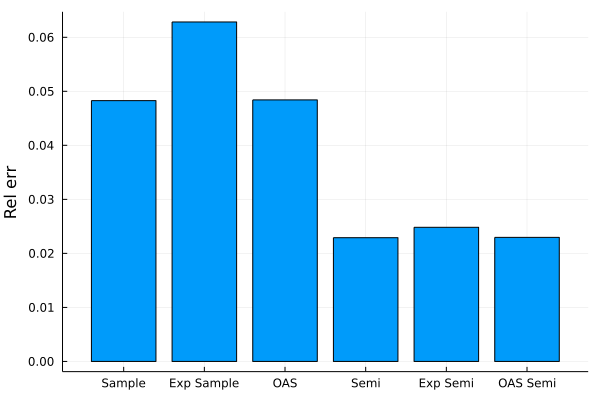

[0.04827333795084753, 0.0628297583608334, 0.04840679544002764, 0.022906141382702475, 0.024828750906271832, 0.022958747397658408]


In [28]:
future_cov = cov(Cov(), future_returns)
future_semi_cov = cov(SCov(), future_returns)

sample_cov = cov(Cov(), past_returns)
e_cov = cov(ECov(), past_returns, span = num_rows / 2)
semi_cov = cov(SCov(), past_returns)
e_semi_cov = cov(ESCov(), past_returns, span = num_rows / 2)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

oas_shrunken_cov = Matrix(cov(CustomCov(), past_returns, estimator = method))
oas_shrunken_cov_semi_cov = Matrix(cov(CustomSCov(), past_returns, estimator = method))

future_var = diag(future_cov)
future_semivar = diag(future_semi_cov)

errors = Float64[]
push!(errors, sum(abs.(future_var - diag(sample_cov))))
push!(errors, sum(abs.(future_var - diag(e_cov))))
push!(errors, sum(abs.(future_var - diag(oas_shrunken_cov))))
push!(errors, sum(abs.(future_semivar - diag(semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(e_semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(oas_shrunken_cov_semi_cov))))

errors /= length(future_var)

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel = "Rel err",
    legend = false,
)

display(fig)

println(errors)

This is a toss up, as the non exponentially weighted covariances did a better job of estimating the correlations between assets than the corresponding exponentially weighted ones. However, shrunken covariances are made to be more stable, so they should be the default choice for long-term investments.

Furthermore, this lends more weight to the concept of using optimisations which account for downside risk such as EffMeanSemivar, CVaR and CDaR optimisations, and using the semicovariance as the input covariance matrix for Black-Litterman and Hierarchical Risk Parity optimisations.

We can do the same for the whole covariance matrices too, which is what the optimisations actually use.

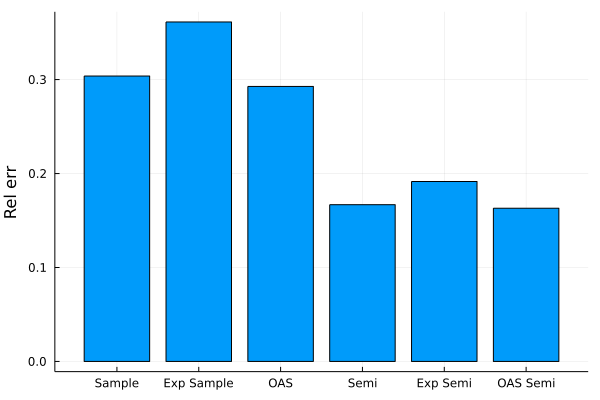

[0.30378672393598116, 0.36131776982053404, 0.29275023859924537, 0.16685498155701559, 0.19155746534756515, 0.1630895155655444]


In [31]:
errors = Float64[]
push!(errors, sum(abs.(future_cov - sample_cov)))
push!(errors, sum(abs.(future_cov - e_cov)))
push!(errors, sum(abs.(future_cov - oas_shrunken_cov)))
push!(errors, sum(abs.(future_semi_cov - semi_cov)))
push!(errors, sum(abs.(future_semi_cov - e_semi_cov)))
push!(errors, sum(abs.(future_semi_cov - oas_shrunken_cov_semi_cov)))

errors /= length(future_var)

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel = "Rel err",
    legend = false,
)

display(fig)

println(errors)

Again, this is a bit of a toss up between choosing exponentially weighted vs not, but the estimation error is again lower when using semicovariances.

If we plot the absolute errors of the correlation matrices we can see that the semicovariance is a more stable measure of the correlation between assets, note how much darker the second plot is compared to the first.

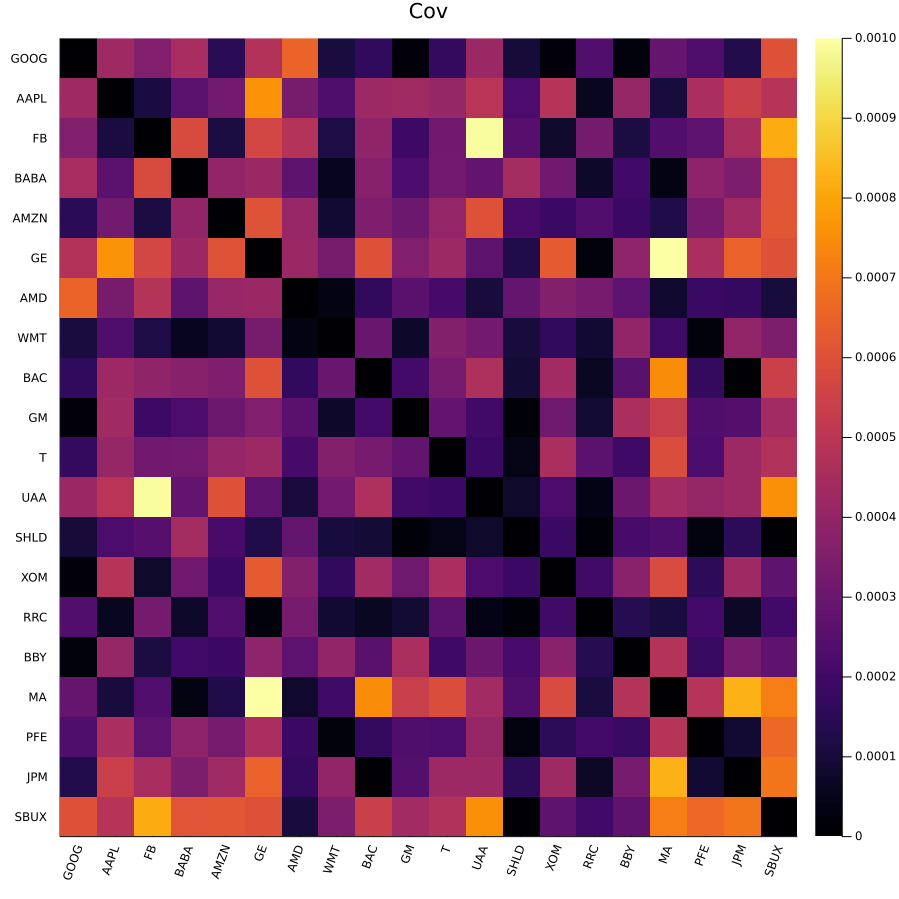

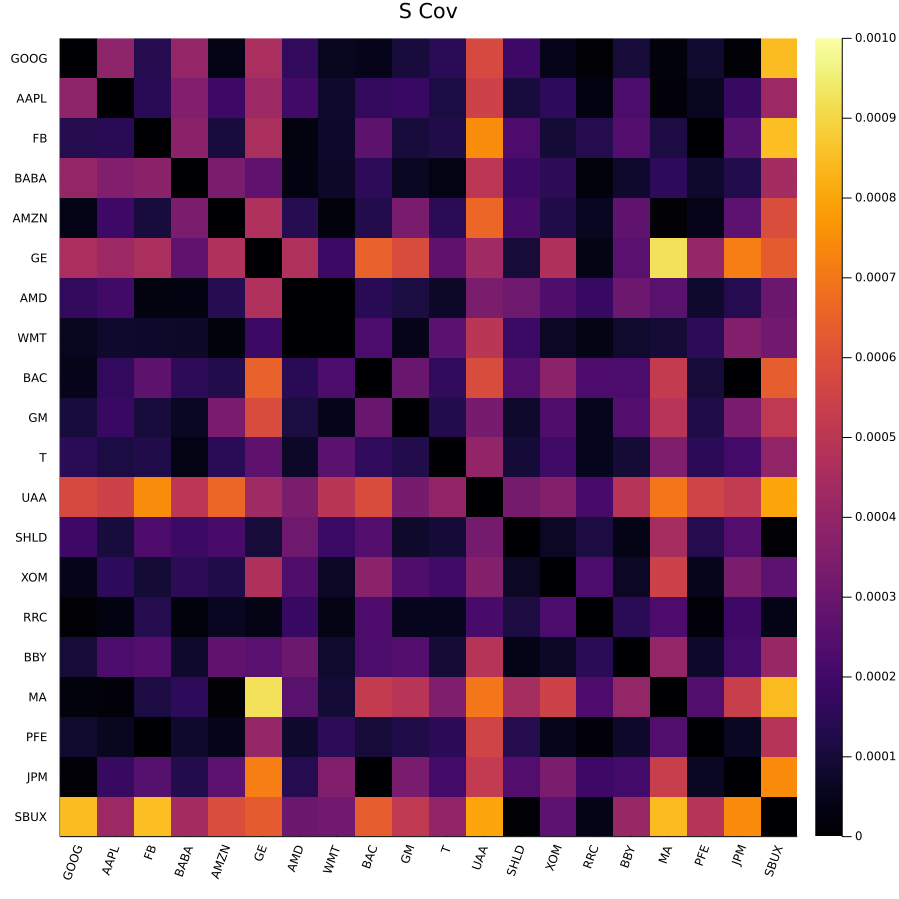

2-element Vector{Nothing}:
 nothing
 nothing

In [59]:
fig1 = plot(heatmap(
    abs.(cov2cor(future_cov) - cov2cor(sample_cov)) / length(future_cov),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-3),
    title = "Cov"
), size = (900, 900))

fig2 = plot(heatmap(
    abs.(cov2cor(future_semi_cov) - cov2cor(semi_cov)) / length(future_semi_cov),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-3),
    title = "S Cov"
), size = (900, 900))

display.([fig1, fig2])